#Ca Simulation

This notebook describes and implements a simulation of calcium imaging data for use to test source extraction methods with ground truth data.

1. Calculating kernel for GCaMP6s

In the CNMF framework, calcium transients are are generated by an AR(2) process. The appendex of [reference] shows that this model is a discrete-time approximation of a continuous model consisting of spikes convolved with a difference of exponential kernel. So to generate the simulation, the first step is to approximate the parameters of this kernel based on the measured response properties of GCaMP6s, given in [reference]. 

The kernel of the continuous process is given by 

$$h(t) = \exp \left(\frac{-t}{\tau_d} \right) - \exp \left(\frac{-t}{\tau_r} \right), $$

where $\tau_r$ is the rise time constant and $\tau_d$ is the decay time constant. [reference] lists values for the transient peak time, $t_{peak}$, and the half decay time $t_{half}$. To solve for $\tau_r$ and $\tau_d$ in terms of $\tau_{peak}$, and $\tau_{half}$, we will solve the follwing system of equations.

$$ h^{\prime} (t_{peak}) = 0$$

$$ h(t_{half}) = \frac{1}{2} h(t_{peak})$$

This system does not appear to have an analytic solution. However, by assuming that $t_{half} >> \tau_r$ so that $\exp \left( \frac{-t_{half}}{\tau_r} \right) \approx 0$, we can use the second equation to solve for $\tau_r$ in terms of $\tau_d$.

After solving for $\tau_r$ in terms of $\tau_d$, we can substitute this the solution into the first equation and use numerical methods to find the solution for $\tau_d$. We can then substitute this back into the simplified second equation to find $\tau_r$. 

This is all done below using SymPy for the algebra and scipy optimize for the numerical methods.

In [1]:
import sympy as sp
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.optimize import brentq, root, fsolve, broyden1
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
import math, random
import imageio
import cv2
%matplotlib inline

t, tau_d, tau_r, t_peak, t_half = sp.symbols('t, tau_d, tau_r, t_peak, t_half')

def h(x):
    return sp.exp(-x/tau_d) - sp.exp(-x/tau_r)

eq1 = sp.Eq(sp.diff(h(t), t).subs(t, t_peak), 0)

eq2 = sp.Eq(sp.exp(-t_half/tau_d) - 0.5*h(t_peak), 0)

display(Math(sp.latex(eq1)))
display(Math(sp.latex(eq2)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

This is the system we will solve. Using the second equation can solve for $\tau_r$:


In [2]:
solutions = sp.solve(eq2, tau_r)
eq_sub = eq1.subs(tau_r, solutions[0])
display(Math(sp.latex(eq_sub)))

<IPython.core.display.Math object>

We can then plug in the values from the literature ($t_{peak}=179$ms and $t_{half}=550$ms). We plot the left hand side as a function of $\tau_d$ to demonstrate that the equation has two solutions for $\tau_d$. and solve for $\tau_d$ using scipy.optimize nonlinear root finder.


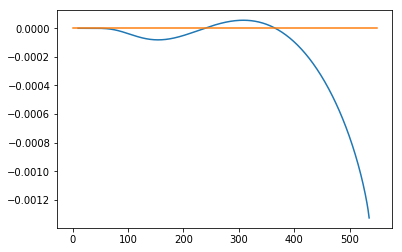

In [3]:

t_peak_val = 179
t_half_val = 550
eq_sub = eq_sub.subs({t_peak:t_peak_val, t_half:t_half_val})
f = sp.lambdify(tau_d, eq_sub.lhs)
times = np.arange(10, 536, 1)
ftime = np.array([f(t) for t in times])

plt.plot(times, ftime)
plt.plot(np.arange(0,t_half_val), np.zeros(t_half_val))

We use the python nonlinear equation sovler to find the two roots of this function. The larger root can be found 

In [4]:
x0 = [200,400] #initial guesses of root
tau_d_vals = np.array([fsolve(f, 200), fsolve(f, 400)])
tau_r_vals = np.zeros_like(tau_d_vals)
for i in range(2):
    tau_r_vals[i] = solutions[0].subs({tau_d:tau_d_vals[i], 
    t_peak:t_peak_val, 
    t_half:t_half_val})
    
print(tau_d_vals)
print(tau_r_vals)

[[238.33273093]
 [365.73079782]]
[[137.83173715]
 [100.49018312]]


Solution 1
	 t_peak: 179.000000
	 t_half: 489.000000
Solution 2
	 t_peak: 179.000000
	 t_half: 542.000000


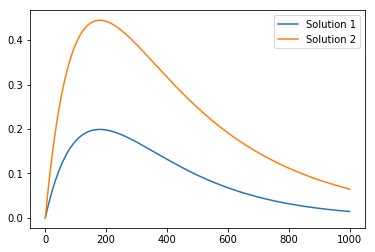

In [5]:
params = ()
times = np.arange(0, 1001, 1)
traces = []
for i in range(2):
    #computing calcium trace for each solution
    h_func = sp.lambdify(t, h(t).subs([(tau_d, tau_d_vals[i]), 
                                       (tau_r, tau_r_vals[i])]))
                  
    trace = np.array([h_func(t) for t in times])
    traces.append(trace)
    
    #getting parameters
    times = np.arange(0, 1000, 1)
    half_height = np.max(trace)/2
    solved_t_half = times[np.logical_and(trace[:-1] > half_height,
                                         trace[1:] <= half_height)]
    solved_t_peak = times[np.argmax(trace)]
    times = np.arange(0, 1001, 1)
    plt.plot(times, trace)
    plt.legend(['Solution 1', 'Solution 2'])
    print("Solution %d"%(i+1))
    print("\t t_peak: %f"%solved_t_peak)
    print("\t t_half: %f"%solved_t_half)

To generate a calcium transient, this calcium trace must be convonved with a spike train that can be generated randomly using the Poisson point process.

[[  0   0   0 ...   0   0   0]
 [  0   1   2 ... 997 998 999]]


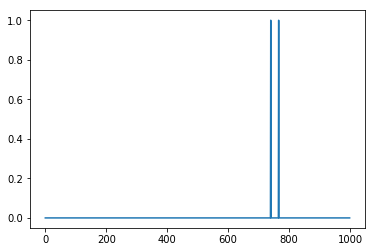

In [6]:
times = np.arange(0, 1000, 1)
fr = 0.5
tSim = 1
dt= (1.0/1000)
nBins = math.floor(tSim/dt)
spikes = []
tbins = list(range(int(nBins)))
for i in range(0, int(nBins)):
    x = random.random()
    if x < fr*dt:
        spikes.append(1)
    else:
        spikes.append(0)

a = np.asarray(spikes)
b = np.asarray(tbins)
c = np.array([a, b])

np.set_printoptions(threshold=50)
print(c)
plt.plot(times, a)

(2000,)


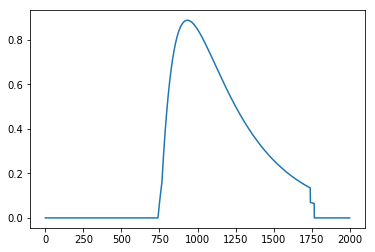

In [7]:
times = np.arange(0, 2000, 1)

calcium_transient = np.convolve(a, traces[1])
plt.plot(times, calcium_transient)
print(np.shape(calcium_transient))

With the calcium transient, the next step is to create a video simulation of calcium imaging. We want to create an empty frame, weight certain pixels in either a circle or square with a normal distribution around the shape's center, then apply our randomly generated calcium transient to each "neuron". 

In [8]:
def display_image(frame):
    im = np.array(frame * 255, dtype = np.uint8)
    threshed = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 0)
    cv2.imshow('image', threshed)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

The cell below is responsible for creating a 2D Gaussian array:

In [52]:
def neuron():
    x, y = np.meshgrid(np.linspace(-1,1,3), np.linspace(-1,1,3))
    d = np.sqrt(x*x+y*y)
    sigma, mu = 1.0, 0.0
    z1 = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    return z1
print("2D Gaussian-like array:")
print(z1)
#display_image(z1)

2D Gaussian-like array:
[[0.36787944 0.60653066 0.36787944]
 [0.60653066 1.         0.60653066]
 [0.36787944 0.60653066 0.36787944]]


In [18]:
z1 = np.ravel(z1)
z1 = np.reshape(z1, (np.size(z1), 1))
ct = np.reshape(calcium_transient, (-1, len(calcium_transient)))
print(np.shape(ct))
print(np.shape(z1))


m = np.matmul(z1, ct)
print(np.shape(m)) #p x t matrix; p = pixels and t = time bins
display_image(m)
print(m.shape[1])

(1, 2000)
(16, 1)
(16, 2000)
2000


In [19]:
pixels = int(m.shape[0])
tbins = int(m.shape[1])


In [20]:
mravel = np.ravel(m, order='F')
v = np.reshape(mravel, (tbins, int(np.sqrt(pixels)), int(np.sqrt(pixels))))
#v = v.astype('uint8')

In [21]:
print(np.shape(v))
print(np.ndim(v))

(2000, 4, 4)
3


With the ability to simulate a single neuron calcium transient, we can now create a large frame to insert many small neurons into:

In [81]:
wall_x = 100
wall_y = 100
wall = np.zeros((wall_x,wall_y),dtype=np.float)
numneurons = 10
i = 0
walls = []
while i < numneurons:
    block = neuron()

    x = np.random.random_integers(0, wall_x - block.shape[0])
    y = np.random.random_integers(0, wall_y - block.shape[1])
    if np.sum(wall[x:x+block.shape[0], y:y+block.shape[1]]) == 0:
        wall[x:x+block.shape[0], y:y+block.shape[1]] = block
        i += 1
        
    else:
        pass

np.set_printoptions(threshold=np.nan)
print(wall)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

C:\Users\dgore\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 97 + 1) instead
  if __name__ == '__main__':
C:\Users\dgore\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 97 + 1) instead
  # Remove the CWD from sys.path while we load stuff.


In [82]:
z1 = np.ravel(wall)
z1 = np.reshape(z1, (np.size(z1), 1))
ct = np.reshape(calcium_transient, (-1, len(calcium_transient)))
print(np.shape(ct))
print(np.shape(z1))


m = np.matmul(z1, ct)
print(np.shape(m)) #p x t matrix; p = pixels and t = time bins
display_image(m)
print(m.shape[1])

(1, 2000)
(10000, 1)
(10000, 2000)
2000


In [83]:
pixels = int(m.shape[0])
tbins = int(m.shape[1])

In [84]:
mravel = np.ravel(m, order='F')
v = np.reshape(mravel, (tbins, int(np.sqrt(pixels)), int(np.sqrt(pixels))))

In [85]:
imageio.mimwrite('simulation.mp4', v , fps = 60, macro_block_size = None)